In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
try:
    connection = engine.connect()
    connection.close()
except Exception as e:
    print("error:", e)

In [23]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine, reflect=True)

In [38]:
base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date = recent_date[0]
print(recent_date)

2017-08-23


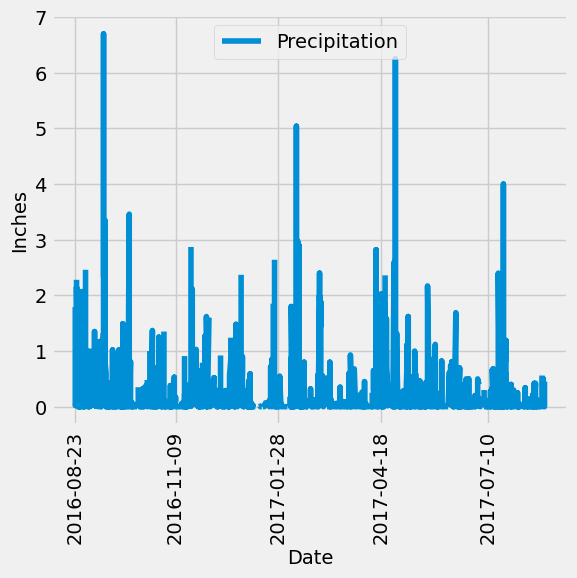

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).\
filter(measurement.date >= one_year_ago).\
filter(measurement.date <= recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_year = pd.DataFrame(result, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_year = precip_year.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the dataplt.figure(figsize=(5, 5))
plt.figure(figsize=(6,6))
plt.plot(precip_year['Date'], precip_year['Precipitation'], label = 'Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
xticks = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(xticks, rotation = 90)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = precip_year['Precipitation'].describe()
print(summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [31]:
# Query to calculate the total number of stations
total_stations = session.query(func.count(func.distinct(measurement.station))).scalar()

print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

print('Active Stations:')
for station, row_count in active_stations:
    print(f'Station: {station}, Rows: {row_count}')

Active Stations:
Station: USC00519281, Rows: 2772
Station: USC00519397, Rows: 2724
Station: USC00513117, Rows: 2709
Station: USC00519523, Rows: 2669
Station: USC00516128, Rows: 2612
Station: USC00514830, Rows: 2202
Station: USC00511918, Rows: 1979
Station: USC00517948, Rows: 1372
Station: USC00518838, Rows: 511


In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station, func.count(measurement.station)).\
                      group_by(measurement.station).\
                      order_by(func.count(measurement.station).desc()).first()


most_active_station_id = most_active_station[0]


result = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
         filter(measurement.station == most_active_station_id).first()

lowest_temp = result[0]
highest_temp = result[1]
average_temp = result[2]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


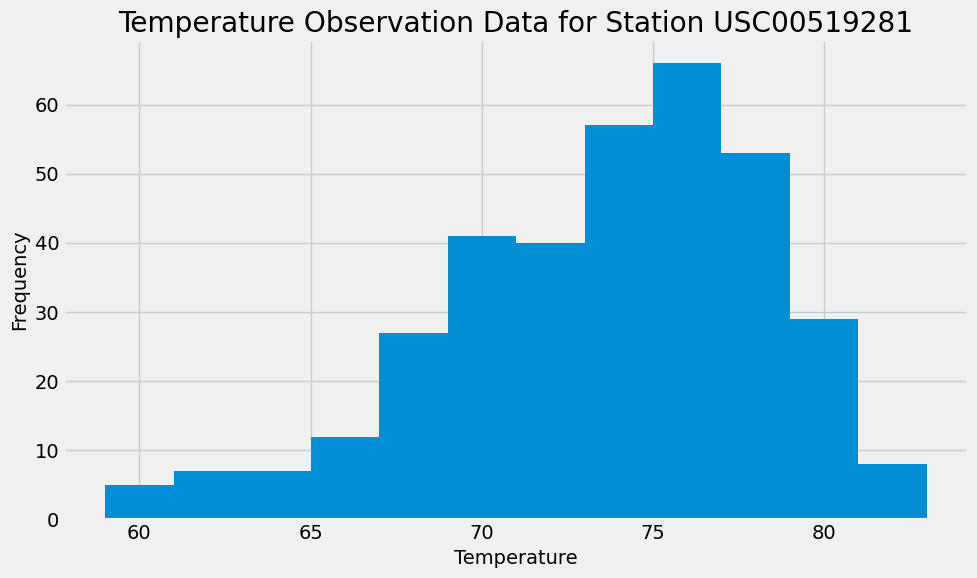

In [35]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


data = session.query(measurement.tobs).\
                      filter(measurement.station == most_active_station_id).\
                      filter(measurement.date >= one_year_ago).\
                      filter(measurement.date <= recent_date).all()

temperature = [result[0] for result in data]

# Plot the temperature data
plt.figure(figsize=(10, 6))
plt.hist(temperature, bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station_id}')
plt.tight_layout()
plt.show()



# Close Session

In [63]:
# Close Session
session.close()